In [ ]:
## This is a series of examples demonstrating the use of the icanswim/qchem repo 
## for quantum mechanic geometric machine learning utilizing pytorch, pyg and rdkit.
## This is a demonstration of the use of the icanswim/cosmosis repo for 
## data science and machine learning projects.

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

import copy
import numpy as np

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad, Flatten, Reshape, SqueezeN, Index

from learning import Learn, Selector
from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import GraphNet, PygModel, EncoderLoss, GraphNetVariationalEncoder 

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T


In [2]:
#example exploring cosmosis/qchem QM9 dataset 
#use the qchem rdkit branch for rdkit data augmentation

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number','mulliken'],
                                                             'coulomb': ['coulomb'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'n': 1000, #non-random subset for testing,
                              'use_pickle': False}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1000
total uncharacterized molecules removed:  25
total molecules created:  975
CDataset created...


{'model_input': {'X': array([ 6.      ,  1.      ,  1.      ,  1.      ,  1.      , -0.535689,
          0.133921,  0.133922,  0.133923,  0.133923], dtype=float32),
  'coulomb': array([[36.858112 , 10.765677 , 10.765888 , 10.765863 , 10.765641 ],
         [ 0.9157932,  0.5      ,  1.7943147,  1.7943105,  1.7942736],
         [ 0.9157932,  1.7942796,  0.5      ,  1.7943105,  1.7942736],
         [ 0.9157932,  1.7942796,  1.7943147,  0.5      ,  1.7942736],
         [ 0.9157932,  1.7942796,  1.7943147,  1.7943105,  0.5      ]],
        dtype=float32)},
 'criterion_input': {'target': array([-40.47893], dtype=float32)}}

In [3]:
#example exploring cosmosis/qchem QM9 dataset

l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

longest molecule index:  228  length:  40
shortest molecule index:  3  length:  6


{'model_input': {'X': array([ 8.      ,  1.      ,  1.      , -0.589706,  0.294853,  0.294853],
        dtype=float32),
  'coulomb': array([[73.51671  , 35.90347  , 35.90347  ],
         [ 1.0393857,  0.5      ,  4.4879336],
         [ 1.0393857,  4.4879336,  0.5      ]], dtype=float32)},
 'criterion_input': {'target': array([-76.4047], dtype=float32)}}

In [4]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output

import copy
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

ds_params = {'train_params': {'dataset': 'QM9',
                              'pg_params': {'root': './data/',
                                            'transform': IndexY(1)}}}

pgds = PGDS(**ds_params['train_params'])
ds_idx = np.arange(1000)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)
print('pgds[1].edge_index: ', pgds[1].edge_index)
print('pgds[1].edge_attr: ', pgds[1].edge_attr)

creating pytorch geometric QM9 dataset...
CDataset created...
batch:  DataBatch(x=[23, 11], edge_index=[2, 44], edge_attr=[44, 4], y=[2], pos=[23, 3], idx=[2], name=[2], z=[23], batch=[23], ptr=[3])
batch.ptr:  tensor([ 0, 12, 23])
batch.idx:  tensor([982, 245])
batch.x:  tensor([[0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 

creating QM9 dataset...
molecules scanned:  1
molecules created:  0
molecules scanned:  10001
molecules created:  9551
total molecules scanned:  10450
total uncharacterized molecules removed:  265
total molecules created:  9735
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.213441
epoch: 0, lr: 0.01
train loss: 119.60328883045125, val loss: 44.03083939985795
learning time: 0:00:12.609554
epoch: 7, lr: 0.01
train loss: 12.290610817243468, val loss: 8.848254377191717
learning time: 0:00:17.110648
epoch: 10, lr: 0.005
train loss: 10.817279635735279, val loss: 12.052620887756348
learning time: 0:00:27.153320
epoch: 17, lr: 0.005
train loss: 7.467681299965337, val loss: 7.407165483994917
test loss: 7.169326478784734
learning time: 0:00:30.337214


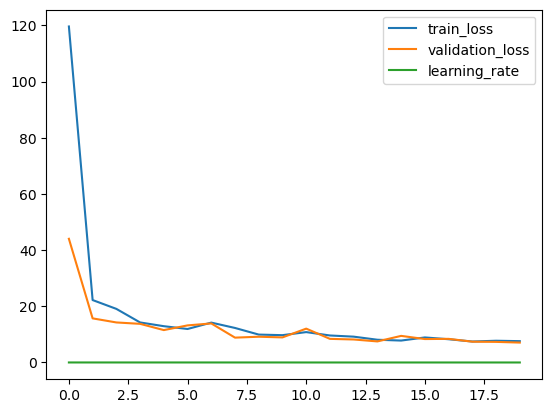

In [5]:
#example cosmosis/qchem QM9 dataset with filter
#use the qchem rdkit branch for rdkit data augmentation

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10000, #non-random subset for testing
                              'transforms': {'coulomb': [Pad((29,29)),Reshape((-1))],
                                             'U0': [SqueezeN()]},
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': False}}

model_params = {'in_channels': 29*29, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }
                
metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          squeeze_y_pred=True, batch_size=128, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.11/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:26.138960
epoch: 0, lr: 0.01
train loss: 1.6749274523652233, val loss: 1.3825721528969313
learning time: 0:00:51.400797
epoch: 1, lr: 0.01
train loss: 1.35417227401119, val loss: 1.3015044104111821
learning time: 0:01:16.536687
epoch: 2, lr: 0.01
train loss: 1.290524656198272, val loss: 1.2299667628187883
learning time: 0:01:41.783915
epoch: 3, lr: 0.01
train loss: 1.235166395411772, val loss: 1.1916861502747786
learning time: 0:02:07.241993
epoch: 4, lr: 0.01
train loss: 1.187713104803689, val loss: 1.1553882619268017
learning time: 0:02:32.264023
epoch: 5, lr: 0.01
train loss: 1.1256408394217825, val loss: 1.1007746261985678
learning time: 0:02:57.236966
epoch: 6, lr: 

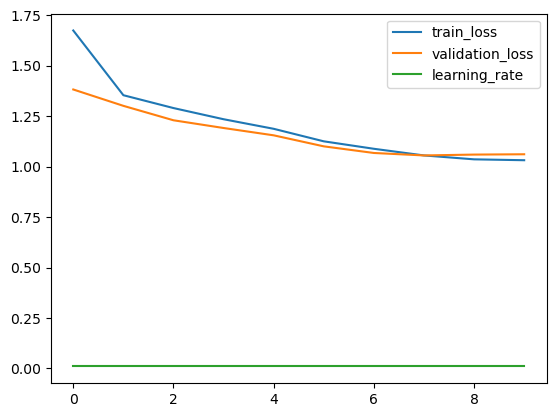

In [6]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        #Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 128, 
                'out_channels': 1,
                'depth': 1,
                'convolution': 'NetConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
                'edge_features': 4,
               }

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0), 
                                                                   ])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.11/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
GraphNetVariationalEncoder loaded...
CModel loaded...
running model on gpu...
learning time: 0:01:18.995513
epoch: 0, lr: 0.01
train loss: 0.011176936018404427, val loss: 0.02088677897757175
sklearn train metric: 0.6143211904854937, sklearn validation metric: 0.561464678064671
learning time: 0:02:36.480782
epoch: 1, lr: 0.01
train loss: 0.010157671069296506, val loss: 0.019770006375277743
sklearn train metric: 0.6913481011088647, sklearn validation metric: 0.7256187562436842
learning time: 0:03:54.672105
epoch: 2, lr: 0.01
train loss: 0.009815091846862457, val loss: 0.019854879530231937
sklearn train metric: 0.750399196556072, sklearn va

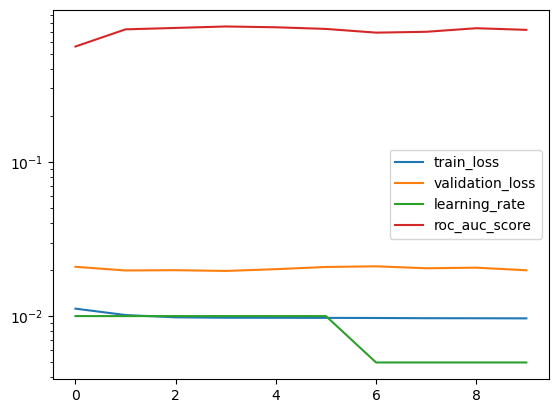

In [2]:
#example graph variational autoencoder without adversarial regulation and GCNConv encoder

model_params = {'in_channels': 11, 
                'hidden': 32, 
                'out_channels': 32,
                'depth': 2,
                'softmax': None,
                'pool': None,
                'convolution': 'GCNConv'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'adversarial': False,
               'disc_params': {'in_channels': 32, 'hidden': 64, 
                                'out_channels': 32, 'softmax': None}}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15),
                 'subset': False}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=128, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.11/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
GraphNetVariationalEncoder loaded...
CModel loaded...
running model on gpu...
FFNet model loaded...
CModel loaded...
learning time: 0:01:33.970896
epoch: 0, lr: 0.01
train loss: 0.023174251712389758, val loss: 0.028681843267644152
sklearn train metric: 0.5064309867423992, sklearn validation metric: 0.5090123918825078
learning time: 0:03:08.548514
epoch: 1, lr: 0.01
train loss: 0.016330727775926358, val loss: 0.03031198332220121
sklearn train metric: 0.5731817005050004, sklearn validation metric: 0.5222976848740333
learning time: 0:04:42.660394
epoch: 2, lr: 0.01
train loss: 0.01607615279515723, val loss: 0.030982221446298305
sklearn trai

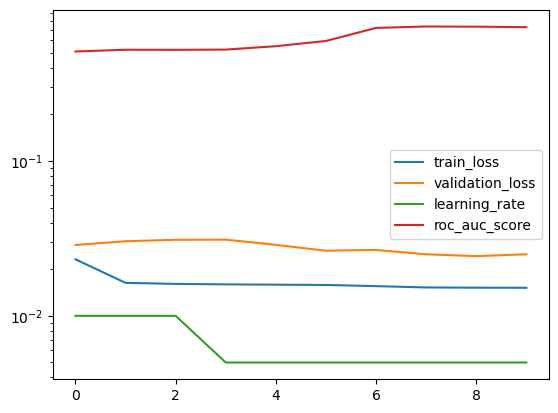

In [2]:
#example graph variational autoencoder with adversarial regulation and GCNConv encoder

model_params = {'in_channels': 11, 
                'hidden': 32, 
                'out_channels': 32,
                'depth': 2,
                'softmax': None,
                'pool': None,
                'convolution': 'GCNConv'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': None}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'adversarial': True,
               'disc_params': {'in_channels': 32, 'hidden': 64, 
                                'out_channels': 32, 'softmax': None}}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15),
                 'subset': False}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=False, batch_size=128, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.11/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:07.620462
epoch: 0, lr: 0.01
train loss: 1.6031447198210644, val loss: 1.2662687003612518
learning time: 0:00:21.005226
epoch: 2, lr: 0.01
train loss: 1.1057505559186642, val loss: 1.1269101359342273
learning time: 0:00:34.951656
epoch: 4, lr: 0.01
train loss: 0.9684736394748634, val loss: 0.9577395147398898
learning time: 0:00:48.867533
epoch: 6, lr: 0.01
train loss: 0.8746619838960364, val loss: 0.8220158901653791
learning time: 0:01:02.349076
epoch: 8, lr: 0.01
train loss: 0.808324235827983, val loss: 0.8389393012774619
learning time: 0:01:15.644372
epoch: 10, lr: 0.01
train loss: 0.7783571553497421, val loss: 0.7763540987905703
learning time: 0:01:29.337186
epoch: 12

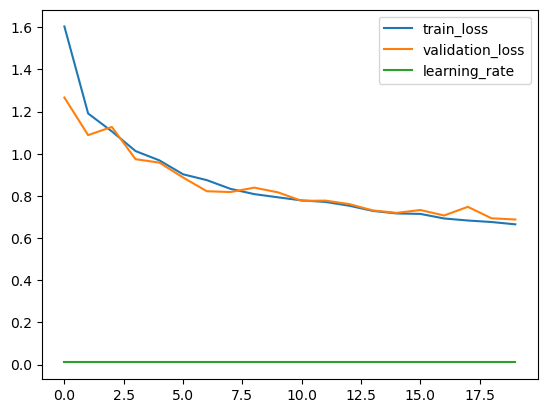

In [2]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
               }

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0), 
                                                                   ])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
pytorch geometric model GraphSAGE loaded...
running model on gpu...
learning time: 0:00:07.197190
epoch: 0, lr: 0.01
train loss: 1.5874459155801297, val loss: 1.3003773901023363
learning time: 0:00:20.808583
epoch: 2, lr: 0.01
train loss: 1.157885210353787, val loss: 1.0970329540340524
learning time: 0:00:34.976165
epoch: 4, lr: 0.01
train loss: 1.0544520568113034, val loss: 1.066874382527251
learning time: 0:00:49.033621
epoch: 6, lr: 0.01
train loss: 1.0159691169816238, val loss: 0.9790357429730264
learning time: 0:01:03.249061
epoch: 8, lr: 0.01
train loss: 0.979600759280496, val loss: 1.0344311414580596
learning time: 0:01:17.823037
epoch: 10, lr: 0.01
train loss: 0.9539404863736877, val loss: 0.9292143575455013
learning time: 0:01:31.934888
epoch: 12, lr: 0.01
train loss: 0.9326075918200303, val loss: 0.9550696219268598
learning time: 0:01:45.920362
epoch: 14, lr: 0.01
train loss: 

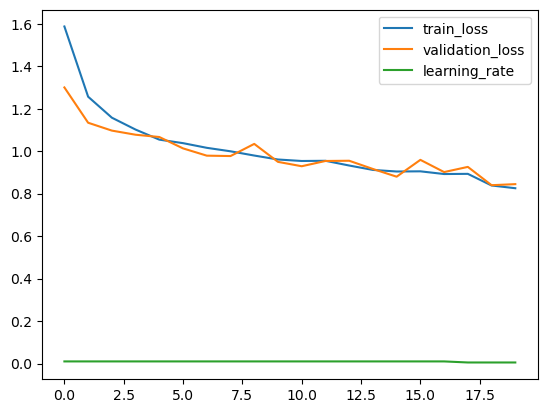

In [3]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'model_name': 'GraphSAGE',
                'softmax': None,
                'pool': 'MeanAggregation',
                'ffnet': True,
                'in_channels': 256, #ffnet params
                'hidden': 256, 
                'out_channels': 1, 
                'pyg_params': {'in_channels': 11, #GraphSAGE params
                               'hidden_channels': 256,
                               'num_layers': 2,
                               'out_channels': 256,
                               'dropout': .1,
                               'norm': 'BatchNorm'}}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0)])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], PygModel, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:06.348310
epoch: 0, lr: 0.01
train loss: 1.4941667146375532, val loss: 1.261011131499943
learning time: 0:00:19.198909
epoch: 2, lr: 0.01
train loss: 1.1461725159853446, val loss: 1.162694095780975
learning time: 0:00:31.901750
epoch: 4, lr: 0.01
train loss: 1.0447496304325028, val loss: 1.0368223221678483
learning time: 0:00:44.450449
epoch: 6, lr: 0.01
train loss: 0.9724689636911664, val loss: 1.0214463221399408
learning time: 0:00:56.950273
epoch: 8, lr: 0.01
train loss: 0.9276320072783142, val loss: 1.0021763326306092
learning time: 0:01:09.765979
epoch: 10, lr: 0.01
train loss: 0.894608169543643, val loss: 0.984628762853773
learning time: 0:01:22.342380
epoch: 12, lr: 0.01
train loss: 0.8545591392103029, val loss: 0.9333584489006745
learning time: 0:01:35.048945
epoch: 14, lr: 0.01
train loss: 0.8167560668218703, val loss: 0.9476600085434

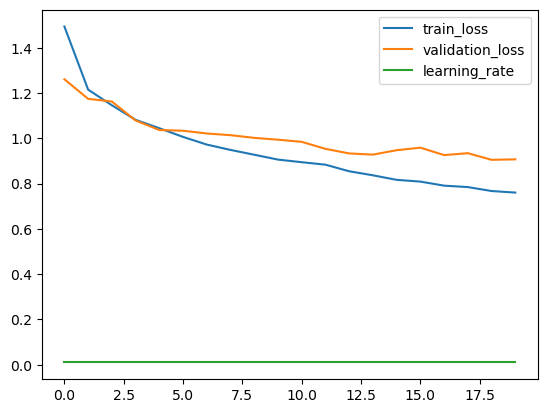

In [9]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom cosmosis model

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {'y': [Index(0)],
                                             'x': [Pad((29,11)), Flatten()]},
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.852023
epoch: 0, lr: 0.01
train loss: 1487.6721384148848, val loss: 1401.9664611816406
learning time: 0:00:08.335194
epoch: 10, lr: 0.01
train loss: 46.99596927040502, val loss: 43.179564476013184
test loss: 38.78383445739746
learning time: 0:00:15.347367


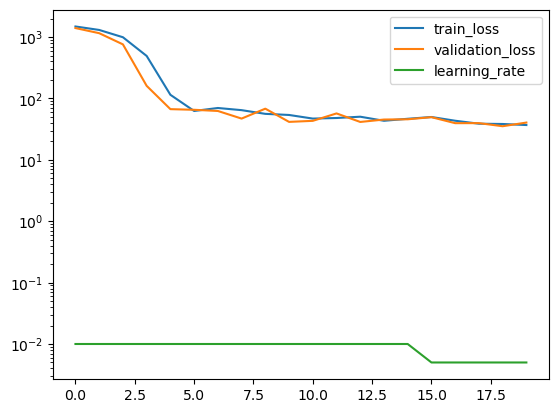

In [5]:
#example using cosmosis/qchem QM7 dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.784253
epoch: 0, lr: 0.01
train loss: 1513.708431846217, val loss: 1431.3775024414062
learning time: 0:00:07.653451
epoch: 10, lr: 0.01
train loss: 64.98444627460681, val loss: 70.27180862426758
test loss: 61.52750015258789
learning time: 0:00:14.014097


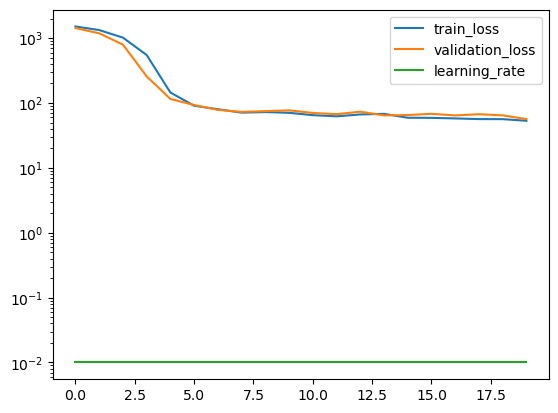

In [6]:
#example using the cosmosis/qchem QM7b dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [7]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {},
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
longest molecule length:  20  index:  233
(20,)


{'model_input': {'X': array([6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.], dtype=float32)},
 'criterion_input': {'target': array([89.35384], dtype=float32)}}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.227238
epoch: 0, lr: 0.01
train loss: 43.96184024810791, val loss: 11.357409000396729
test loss: 3.531156539916992
learning time: 0:00:07.968128


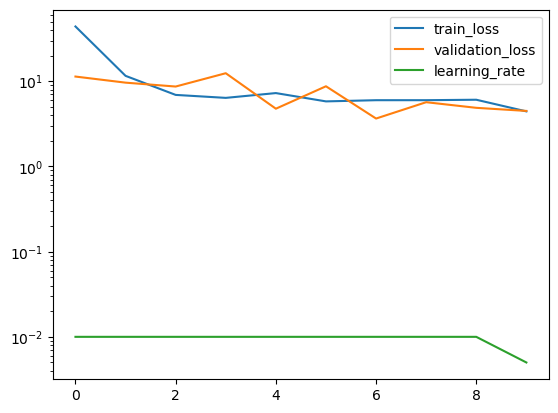

In [3]:
#example using the cosmosis/qchem QM7X dataset with filter and custom cosmosis model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {'coulomb': [Pad((23,23)), Flatten()]},
                              'selector': ['opt'],
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}


opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.240802
epoch: 0, lr: 0.01
train loss: 457.9350747501149, val loss: 272.0658438546317
learning time: 0:00:12.232179
epoch: 10, lr: 0.01
train loss: 33.10776222453398, val loss: 31.107430866786412
test loss: 28.233738490513392
learning time: 0:00:22.368330


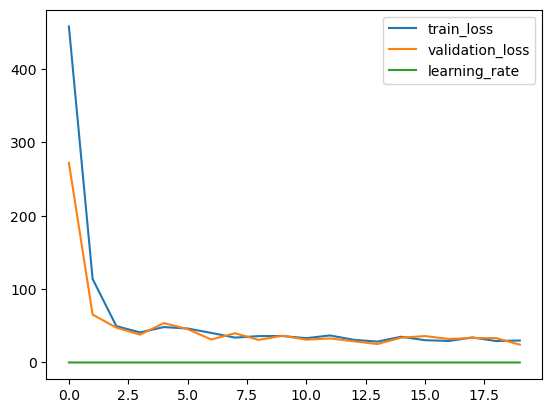

In [4]:
#example using cosmosis/qchem ANI1x dataset with filter and custom cosmosis model

model_params = {'in_channels': 63*63, #length of the longest molecule in the dataset
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'transforms': {'coulomb': [Pad((63,63)), Flatten()]},
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1,
                'min_lr': .005}

opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=20)